# AR(2) Model

This note simulates a basic AR(2).

$$y_t = \mu + \rho_1 y_{t-1} + \rho_2 y_{t-2} + \epsilon_t , \quad \epsilon_t \sim N_{0,\sigma^2}, \quad t=3,\dots,\tau$$

See the graphs below and code for information about the priors and inference, which is a structured (full-rank) VI procedure.

## Preliminaries

In [1]:
# !pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl >/dev/null && echo OK
# !pip3 install torchvision > /dev/null && echo OK
# !pip3 uninstall -y ptvi >/dev/null && echo OK
# !pip3 install git+https://github.com/kuperov/ptvi.git  >/dev/null && echo OK

## Model definition

In [2]:
import math
import torch
from torch.distributions import Normal, LogNormal, Beta
from ptvi import *

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

Define the true parameter values and generate data.

In [4]:
μ, ρ1, ρ2, σ = 1.5, 0.2, 0.1, 1.5
τ = 1000
data_seed, algo_seed = 123, 123

In [5]:
torch.manual_seed(data_seed)
params = dict(μ=μ, ρ1=ρ1, ρ2=ρ2, σ=σ)
model = AR2(input_length=τ, dtype=torch.float64, device=torch.device('cuda'))
y = model.simulate(**params)

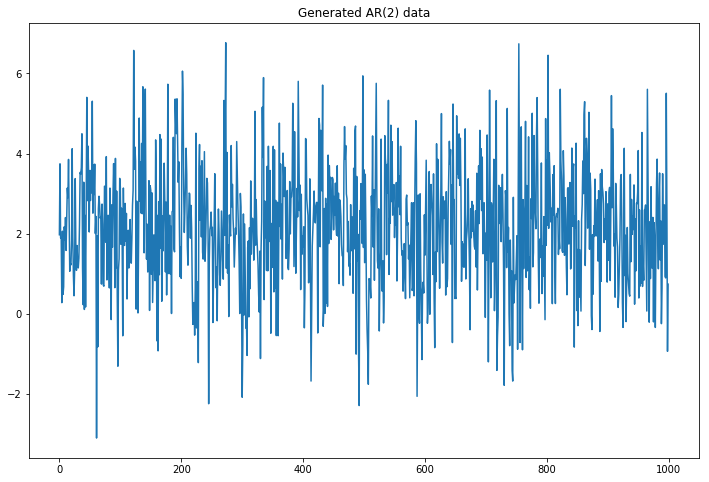

In [6]:
plt.plot(y.cpu().numpy())
plt.title('Generated AR(2) data');

## MAP inference

In [7]:
mfit = map(model, y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
MAP inference with L-BFGS: AR(2) model
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. log joint = -2408.1623
       1. log joint = -1820.2708
       2. log joint = -1820.2708
Convergence criterion met.
       2. log joint = -1820.2708
Completed 3 iterations in 0.14s @ 21.38 i/s.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [8]:
mfit.summary()

,mean,sd
μ,1.569140,0.047006
ρ1,0.155853,0.018360
ρ2,0.109981,0.018190
σ,1.484778,0.032847


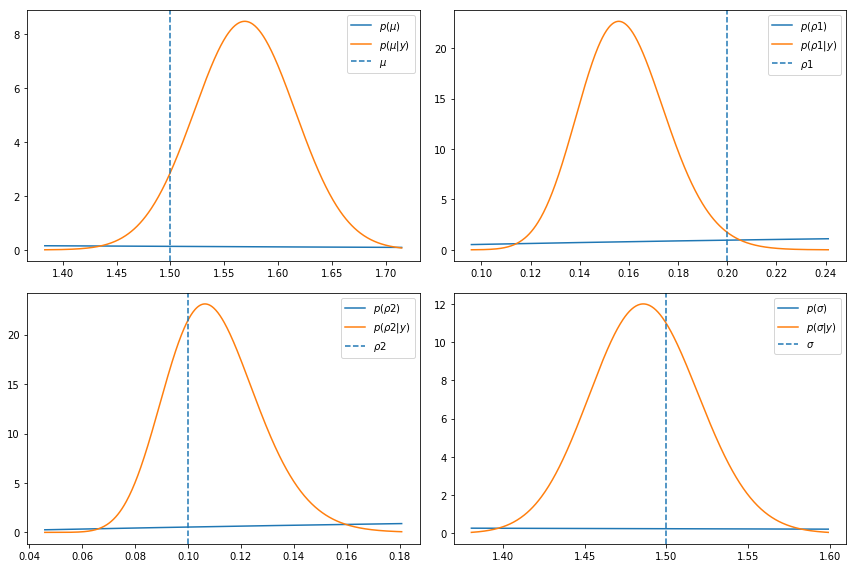

In [9]:
mfit.plot_global_marginals(**params)

## Variational inference (warm start)

We seed the variational inference using the MAP, which gives a really good speed-up.

In [10]:
torch.manual_seed(algo_seed)
u0, L0 = mfit.initial_conditions()
stop_h = SupGrowthStoppingHeuristic(skip=5, min_steps=15, patience=10)
vfit = sgvb(model, y, u0=u0, L0=L0, stop_heur=stop_h)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference: AR(2) model
  - Using torch.float64 precision on cuda
  - Estimating elbo with M=1
  - Minimum supremum growth heuristic (min_steps=75, patience=10, skip=5, ε=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed elbo =-1829.25
       1. smoothed elbo =-1829.00
       2. smoothed elbo =-1828.88
       4. smoothed elbo =-1828.52
       8. smoothed elbo =-1828.04
      16. smoothed elbo =-1828.18
      32. smoothed elbo =-1827.35
      64. smoothed elbo =-1826.70
     128. smoothed elbo =-1826.45
Stopping heuristic criterion satisfied
     170. smoothed elbo =-1826.38
Completed 171 iterations in 1.2s @ 144.22 i/s.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


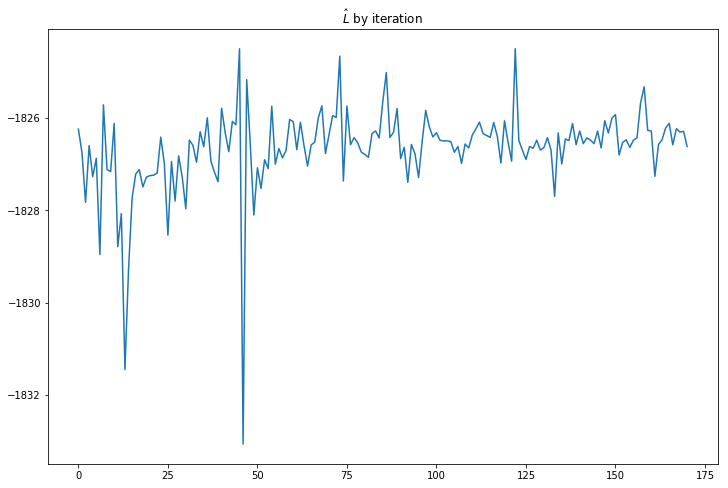

In [11]:
vfit.plot_elbos()

In [12]:
vfit.summary()

,mean,sd
μ,1.575532,0.083847
ρ1,0.158758,0.028234
ρ2,0.107773,0.023529
σ,1.497680,0.034297


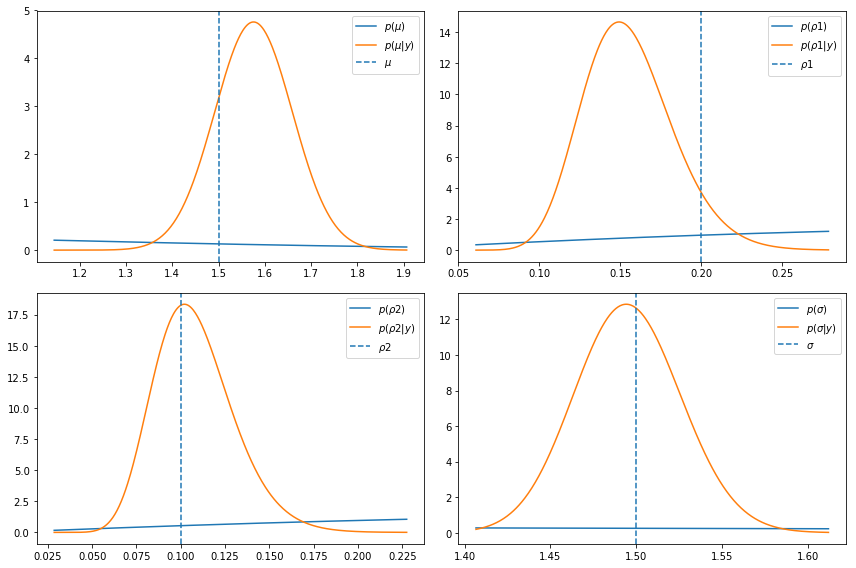

In [13]:
vfit.plot_global_marginals(**params)

### Forecasts

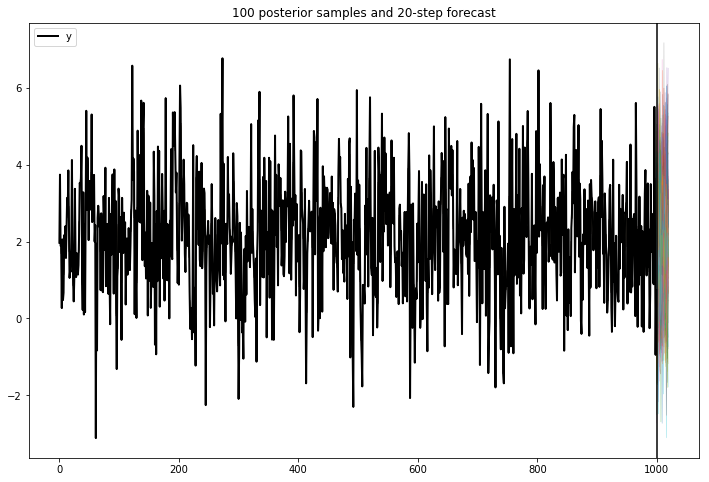

In [14]:
vfit.plot_sample_paths(N=100, true_y=y, fc_steps=20)

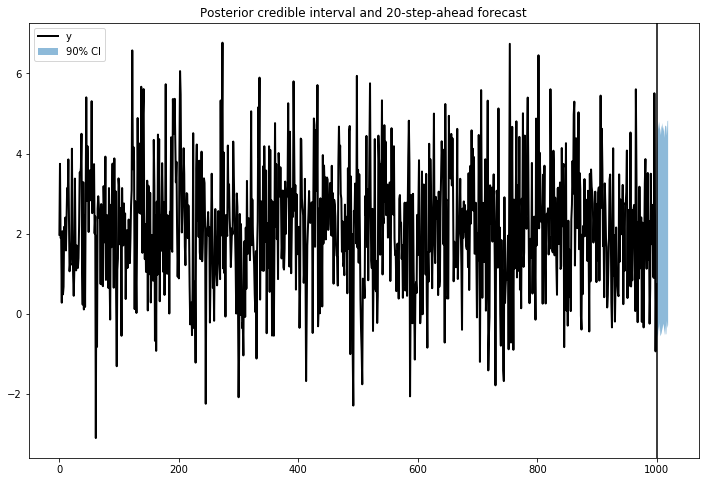

In [15]:
vfit.plot_pred_ci(N=500, α=.1, true_y=y, fc_steps=20)

## Variational inference (cold start)

For comparion, we'll do the same VI algorithm but starting at (0, I).

In [16]:
torch.manual_seed(algo_seed)
cfit = sgvb(model, y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference: AR(2) model
  - Using torch.float64 precision on cuda
  - Estimating elbo with M=1
  - Minimum supremum growth heuristic (min_steps=500, patience=20, skip=10, ε=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed elbo =-4677.16
       1. smoothed elbo =-4555.09
       2. smoothed elbo =-4327.70
       4. smoothed elbo =-4318.84
       8. smoothed elbo =-4560.87
      16. smoothed elbo =-4951.99
      32. smoothed elbo =-11974.09
      64. smoothed elbo =-6513.86
     128. smoothed elbo =-7759.20
     256. smoothed elbo =-4524.87
     512. smoothed elbo =-3097.93
    1024. smoothed elbo =-2215.87
    2048. smoothed elbo =-1834.78
Stopping heuristic criterion satisfied
    3040. smoothed elbo

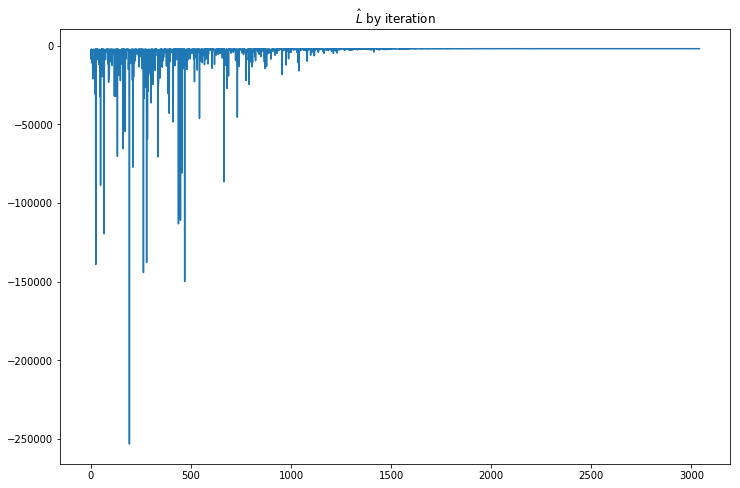

In [17]:
cfit.plot_elbos()

In [18]:
cfit.summary()

,mean,sd
μ,1.579391,0.098248
ρ1,0.151141,0.033638
ρ2,0.104131,0.025653
σ,1.490827,0.032769


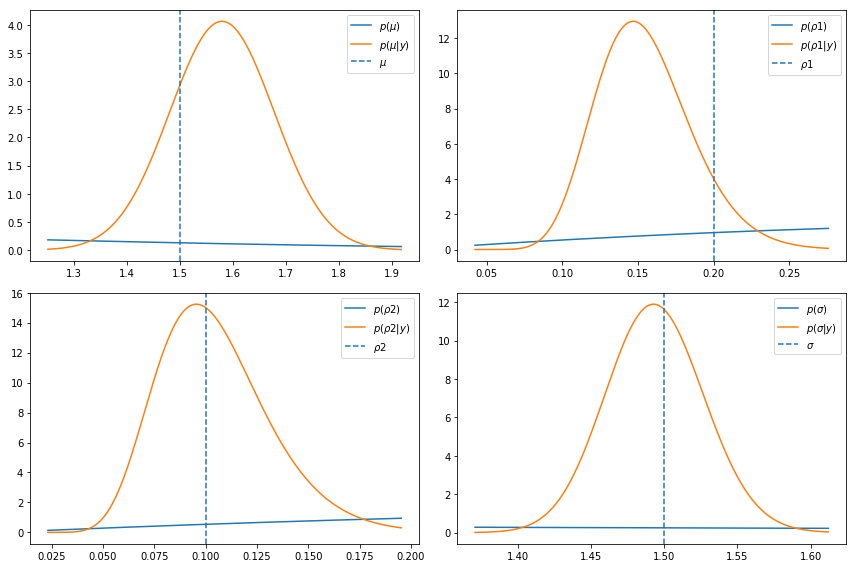

In [19]:
cfit.plot_global_marginals(**params)

### Forecasts

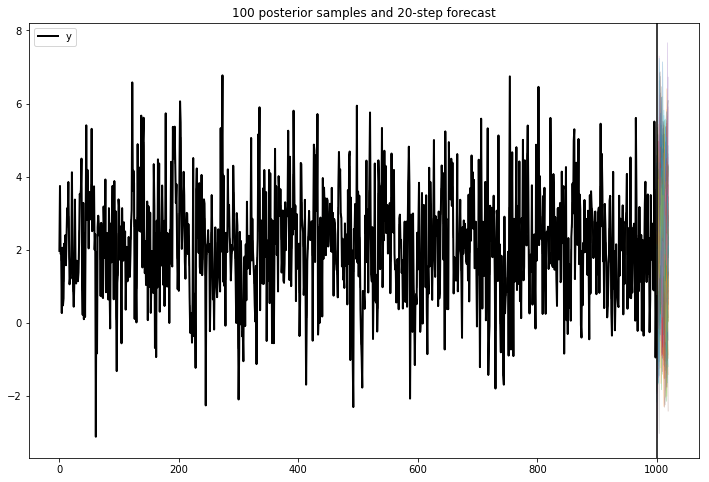

In [20]:
cfit.plot_sample_paths(N=100, true_y=y, fc_steps=20)

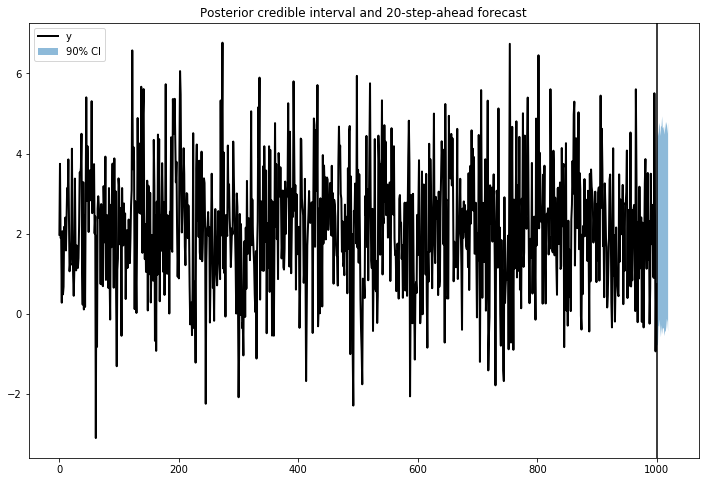

In [21]:
cfit.plot_pred_ci(N=500, α=.1, true_y=y, fc_steps=20)